In [1]:
import cv2
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import warnings
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.layers import Activation,BatchNormalization,Conv2D,Dense,Dropout,Flatten,MaxPool2D,Input
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2

2025-02-09 16:30:33.476516: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## *checking the data*

In [2]:
warnings.filterwarnings('ignore')

In [3]:
# Enable legacy convolution operations (Fix for grouped convolutions issue)
os.environ["TF_USE_LEGACY_FUSED_CONV"] = "1"

In [4]:
hap = cv2.imread('/Volumes/JavaAOT/Documents/AI/ml_expressions/img_datasets/fer_2013_dataset/test/happiness/PrivateTest_218533.jpg')

In [5]:
type(hap)

numpy.ndarray

In [6]:
hap.shape

(48, 48, 3)

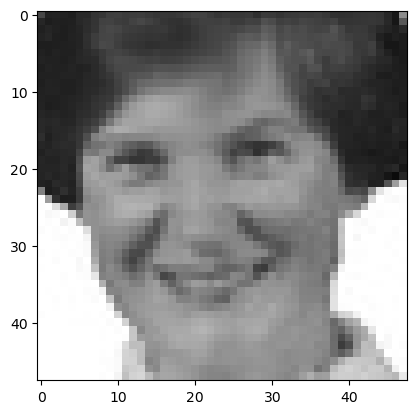

In [7]:
plt.imshow(hap);

In [8]:
dis = cv2.imread('/Volumes/JavaAOT/Documents/AI/ml_expressions/img_datasets/fer_2013_dataset/test/disgust/PrivateTest_3929526.jpg')

In [9]:
type(dis)

numpy.ndarray

In [10]:
dis.shape

(48, 48, 3)

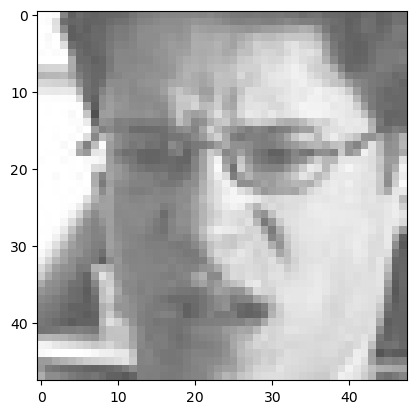

In [11]:
plt.imshow(dis);

## *preprocessing the data*

In [12]:
image_gen = ImageDataGenerator(rotation_range=30,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               rescale=1/255,
                               shear_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               fill_mode='nearest',
                              )

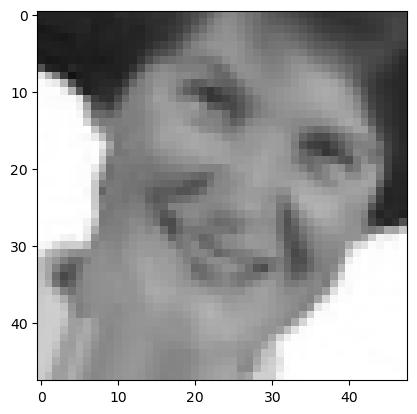

In [13]:
plt.imshow(image_gen.random_transform(hap));

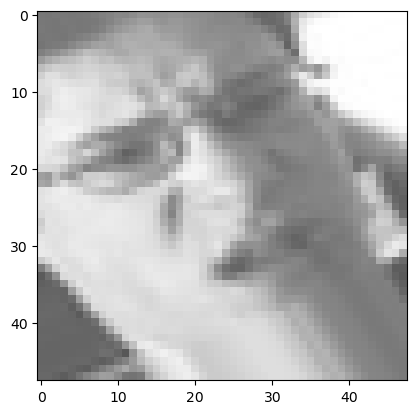

In [14]:
plt.imshow(image_gen.random_transform(dis));

In [15]:
# Define the directory paths and parameters
batch_size = 16
image_shape = (48, 48, 1)
train_dir = '/Volumes/JavaAOT/Documents/AI/ml_expressions/img_datasets/fer_2013_dataset/train'
test_dir = '/Volumes/JavaAOT/Documents/AI/ml_expressions/img_datasets/fer_2013_dataset/test'

In [16]:
# Create training image generator
train_image_gen = image_gen.flow_from_directory(
    train_dir,
    target_size=image_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
)

Found 28709 images belonging to 7 classes.


In [17]:
# Create testing image generator
test_image_gen = image_gen.flow_from_directory(
    test_dir,
    target_size=image_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
)

Found 7178 images belonging to 7 classes.


In [18]:
train_image_gen.class_indices

{'anger': 0,
 'disgust': 1,
 'fear': 2,
 'happiness': 3,
 'neutral': 4,
 'sadness': 5,
 'surprise': 6}

In [19]:
model = Sequential([
    Input(shape=(48, 48, 1)),  # Input shape for FER2013
    Conv2D(64, (3, 3), activation="relu", padding="same"),
    BatchNormalization(),
    MaxPool2D((2, 2)),
    Dropout(0.2),

    Conv2D(128, (3, 3), activation="relu", padding="same"),
    BatchNormalization(),
    MaxPool2D((2, 2)),
    Dropout(0.2),

    Conv2D(256, (3, 3), activation="relu", padding="same"),
    BatchNormalization(),
    MaxPool2D((2, 2)),
    Dropout(0.3),

    Flatten(),
    Dense(512, activation="relu", kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(7, activation="softmax")  # 7 output classes
])

# Compile the model
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       73856     
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24, 128)      5

2025-02-09 16:30:54.359007: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Trainable params: 5,093,255
Non-trainable params: 896
_________________________________________________________________


In [20]:
early_stopping = EarlyStopping(
    monitor='val_loss',             # 1. This specifies that the callback will monitor the validation loss.
    patience=10,                     # 2. If the monitored quantity (val_loss) does not improve for 5 consecutive epochs, training will be stopped.
    min_delta=0.01,                 # 3. Only consider an epoch as "improved" if the validation loss drops by at least 0.01.
    restore_best_weights=True,      # 4. After stopping, the model weights will be reverted to those of the epoch with the best (lowest) validation loss.
    verbose=1                       # 5. Enables detailed logging so that you are informed when early stopping triggers.
)

In [21]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',     # 1. This specifies that the callback will monitor the validation loss.
    factor=0.5,             # 2. When triggered, the learning rate will be reduced to 50% of its current value.
    min_delta=0.01,         # 3. Only trigger LR reduction if the loss improvement is less than 0.01.
    patience=3,             # 4. The learning rate will be reduced if no improvement in validation loss is observed for 3 epochs.
    verbose=1               # 5. Enables detailed logging so that you can see when the learning rate is reduced.
)

In [22]:
# Dynamically Compute Steps per Epoch
steps_per_epoch = max(1, train_image_gen.samples // train_image_gen.batch_size)
validation_steps = max(1, test_image_gen.samples // test_image_gen.batch_size)

In [23]:
results = model.fit(train_image_gen,epochs=100,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=test_image_gen,
                    validation_steps=validation_steps,
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/100
1794/1794 [==============================] - 390s 216ms/step - loss: 2.6646 - accuracy: 0.2427 - val_loss: 1.9761 - val_accuracy: 0.2804 - lr: 0.0010
Epoch 2/100
1794/1794 [==============================] - 381s 212ms/step - loss: 1.9140 - accuracy: 0.2773 - val_loss: 1.9490 - val_accuracy: 0.2725 - lr: 0.0010
Epoch 3/100
1794/1794 [==============================] - 381s 212ms/step - loss: 1.8743 - accuracy: 0.3005 - val_loss: 1.7927 - val_accuracy: 0.3345 - lr: 0.0010
Epoch 4/100
1794/1794 [==============================] - 376s 209ms/step - loss: 1.8072 - accuracy: 0.3185 - val_loss: 1.8282 - val_accuracy: 0.3189 - lr: 0.0010
Epoch 5/100
1794/1794 [==============================] - 376s 210ms/step - loss: 1.7824 - accuracy: 0.3476 - val_loss: 1.9224 - val_accuracy: 0.2832 - lr: 0.0010
Epoch 6/100
1794/1794 [==============================] - 374s 208ms/step - loss: 1.7542 - accuracy: 0.3793 - val_loss: 1.7101 - val_accuracy: 0.4083 - lr: 0.0010
Epoch 7/100
1794/1794 [=====

In [24]:
model.save("basic_cnn_fer_model.keras", save_format="keras")

In [1]:
model.save("basic_cnn_fer_model_2", save_format="tf")
print("CNN model saved successfully as 'final_cnn_model'.")

NameError: name 'model' is not defined